In [1]:
from datasets import load_dataset
emotions = load_dataset("emotion")

/opt/conda/lib/python3.10/site-packages/datasets/load.py:1461: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [2]:
from transformers import AutoTokenizer, AutoModel
import torch

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = AutoModel.from_pretrained(model_ckpt).to(device)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [3]:
 def tokenize(batch):
     return tokenizer(batch["text"], padding=True, truncation=True)

In [4]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [5]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [6]:
#  print(emotions_encoded["train"].column_names)

In [7]:
import torch

def extract_hidden_states(batch, model, tokenizer, device):
    # Place model inputs on the GPU
    inputs = {k: v.to(device) for k, v in batch.items()
              if k in tokenizer.model_input_names}
    
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()}


In [8]:
 emotions_encoded.set_format("torch",
 columns=["input_ids", "attention_mask", "label"])

In [9]:
emotions_hidden = emotions_encoded.map(lambda batch: extract_hidden_states(batch, model, tokenizer, device), batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [10]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [11]:
import numpy as np
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

In [12]:
import pandas as pd 
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

2024-05-29 20:07:07.304087: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-29 20:07:07.304210: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-29 20:07:07.433966: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


,X,Y,label
0,4.197207,6.849838,0
1,-3.029154,6.557125,0
2,5.063339,3.383912,3
3,-2.278035,4.356191,2
4,-3.571332,4.424175,3


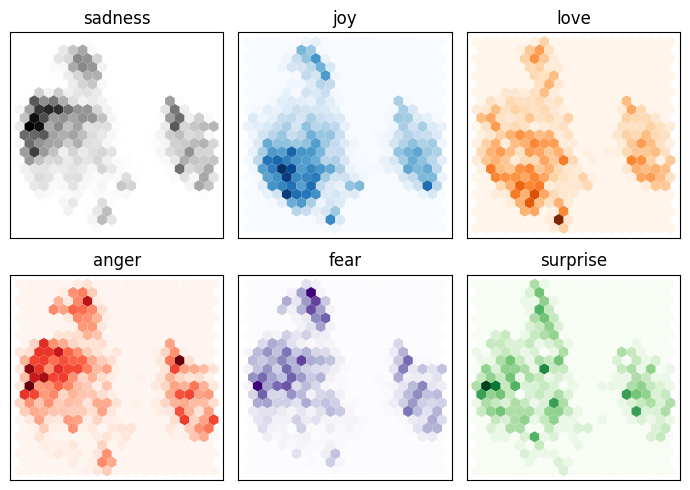

In [13]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(7, 5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")  # Assuming df_emb is defined elsewhere
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, gridsize=20, linewidths=0)
    axes[i].set_title(label)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

plt.tight_layout()
plt.show()


In [14]:
from sklearn.linear_model import LogisticRegression
# increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.633

In [15]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

In [16]:
from transformers import AutoModelForSequenceClassification
num_labels = 6
model = (AutoModelForSequenceClassification
.from_pretrained(model_ckpt, num_labels=num_labels)
.to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [18]:
from transformers import Trainer, TrainingArguments
batch_size = 64

logging_steps = len(emotions_encoded["train"]) // batch_size

model_name = f"{model_ckpt}-finetuned-emotion"

training_args = TrainingArguments(output_dir=model_name,
                     num_train_epochs=2,
                     learning_rate=2e-5,
                     per_device_train_batch_size=batch_size,
                     per_device_eval_batch_size=batch_size,
                     weight_decay=0.01,
                     evaluation_strategy="epoch",
                     disable_tqdm=False,
                     logging_steps=logging_steps,
                     log_level="error")

In [19]:
 from transformers import Trainer

trainer = Trainer(model=model, 
                    args=training_args,
                    compute_metrics=compute_metrics,
                    train_dataset=emotions_encoded["train"],
                    eval_dataset=emotions_encoded["validation"],
                    tokenizer=tokenizer)

trainer.train();

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.575439,0.813500,0.783909
2,0.765700,0.368720,0.891000,0.886081


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [20]:
preds_output = trainer.predict(emotions_encoded["validation"])

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [21]:
y_preds = np.argmax(preds_output.predictions, axis=1)

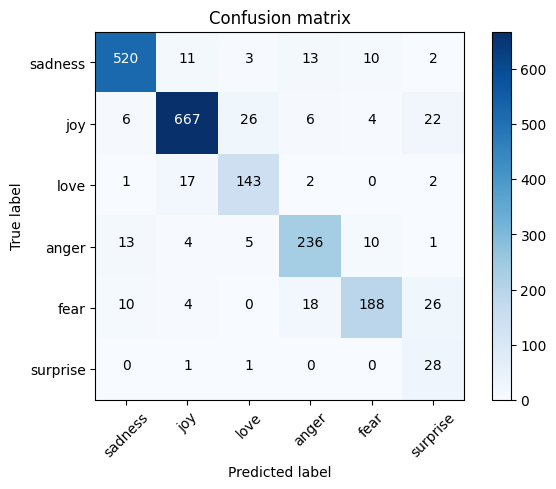

In [22]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plot_confusion_matrix(y_preds, y_valid, labels)

In [23]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
    
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), reduction="none")
    
    # Place outputs on CPU for compatibility with other dataset columns
    return {
        "loss": loss.cpu().numpy(),
        "predicted_label": pred_label.cpu().numpy()
    }

In [24]:
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch",
columns=["input_ids", "attention_mask", "label"])

In [25]:
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(
forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [26]:
def label_int2str(label_int):
    # Define a mapping from integer labels to string labels
    label_map = {0: "sadness", 1: "joy", 2: "love", 3: "anger",4:"fear",5:"surprise"}
    return label_map[label_int]

In [27]:
#create a DataFrame with the texts, losses, and predicted/true labels:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
.apply(label_int2str))

In [28]:
# largest loss
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1950,i as representative of everything thats wrong ...,surprise,sadness,4.833148
882,i feel badly about reneging on my commitment t...,love,sadness,4.807926
1801,i feel that he was being overshadowed by the s...,love,sadness,4.749250
1963,i called myself pro life and voted for perry w...,joy,sadness,4.726825
1870,i guess i feel betrayed because i admired him ...,joy,sadness,4.699743
1274,i am going to several holiday parties and i ca...,joy,sadness,4.626565
765,i feel super awkward and out of place right now,joy,sadness,4.482888
318,i felt ashamed of these feelings and was scare...,fear,sadness,4.170843
1500,i guess we would naturally feel a sense of lon...,anger,sadness,4.139148
465,i would eventually go in to these stores but i...,joy,fear,4.053500


In [29]:
#smallest loss
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
394,i feel shamed that i hoped for one last christ...,sadness,sadness,0.045880
244,im kinda relieve but at the same time i feel d...,sadness,sadness,0.046078
189,i leave the meeting feeling more than a little...,sadness,sadness,0.046157
1531,i forgive stanley hes not so quick to forgive ...,sadness,sadness,0.046318
549,i just feel awful and unlovable and thoroughly...,sadness,sadness,0.046447
1861,im tired of feeling lethargic hating to work o...,sadness,sadness,0.047067
69,i have no extra money im worried all of the ti...,sadness,sadness,0.047380
981,i would have to get off and walk the hill whic...,sadness,sadness,0.047523
1303,i feel pathetic and uninspired,sadness,sadness,0.047635
1368,i started this blog with pure intentions i mus...,sadness,sadness,0.047842
